<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/new_1/Modelling_LogOHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+'train_Log Transformed with One Hot Encoding.pkl' #log transformed
test_file = file_path+ 'test_Log Transformed with One Hot Encoding.pkl'
dataset= "Log Transformed OHE"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 446), (11403, 446), (75818, 446))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [9]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [10]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


The best auc score was 0.812
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 10.9 s, sys: 1.28 s, total: 12.2 s
Wall time: 4min 43s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed OHE dataset 		 



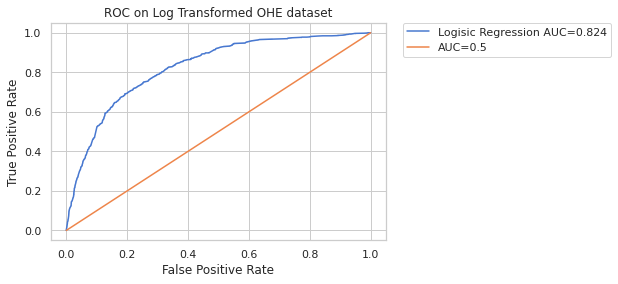

The log loss and auc was found to be 0.519 and 0.824 for Logisic Regression on Log Transformed OHE dataset.


In [ ]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365


# Decision Trees

In [11]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [12]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished


The best auc score was 0.790
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 1000}
CPU times: user 5.57 s, sys: 253 ms, total: 5.82 s
Wall time: 6min 27s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features=None,
                                                             max_leaf_nodes=100,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
        

		 Decision Tree Classifier on Log Transformed OHE dataset 		 



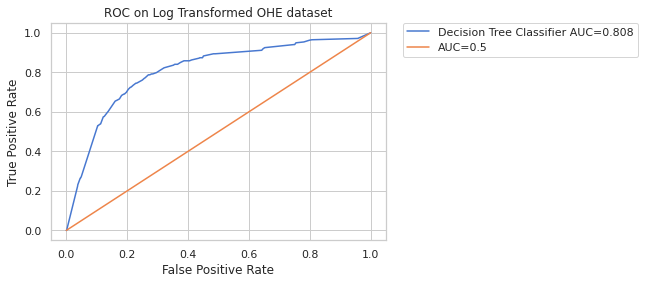

The log loss and auc was found to be 0.141 and 0.808 for Decision Tree Classifier on Log Transformed OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561


# Random Forest

In [13]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [14]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 75.3min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 3min 26s, sys: 674 ms, total: 3min 27s
Wall time: 1h 18min 43s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 5min 17s, sys: 2.08 s, total: 5min 19s
Wall time: 2min 42s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed OHE dataset 		 



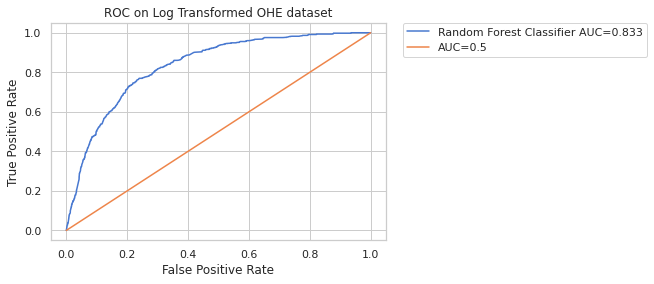

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier on Log Transformed OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055


# Selecting top features

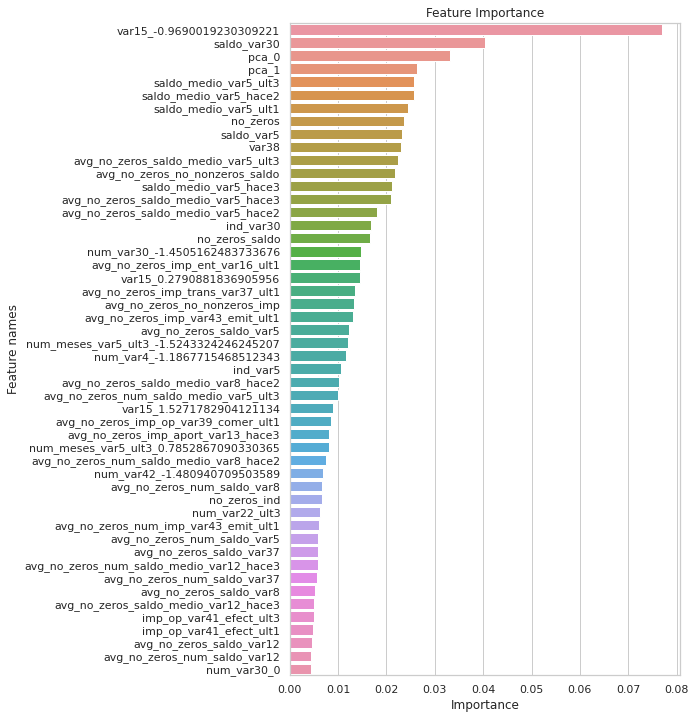

In [ ]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [17]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_test[features].copy()

Taking top 250 features


# XGB Classifier

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.,
                      max_depth=5, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.79463	validation_0-error:0.040077
[1]	validation_0-auc:0.813516	validation_0-error:0.039551
[2]	validation_0-auc:0.821514	validation_0-error:0.039551
[3]	validation_0-auc:0.81602	validation_0-error:0.039551
[4]	validation_0-auc:0.819795	validation_0-error:0.039551
[5]	validation_0-auc:0.825273	validation_0-error:0.039551
[6]	validation_0-auc:0.825925	validation_0-error:0.039551
[7]	validation_0-auc:0.826827	validation_0-error:0.039551
[8]	validation_0-auc:0.828134	validation_0-error:0.039551
[9]	validation_0-auc:0.828406	validation_0-error:0.039551
[10]	validation_0-auc:0.828002	validation_0-error:0.039551
[11]	validation_0-auc:0.827996	validation_0-error:0.039551
[12]	validation_0-auc:0.827338	validation_0-error:0.039551
[13]	validation_0-auc:0.827359	validation_0-error:0.039551
[14]	validation_0-auc:0.82799	validation_0-error:0.039551
[15]	validation_0-auc:0.828445	validation_0-error:0.039551
[16]	validation_0-auc:0.829067	validation_0-error:0.039551
[17]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

		 XGBoost Classifer on Log Transformed OHE dataset 		 



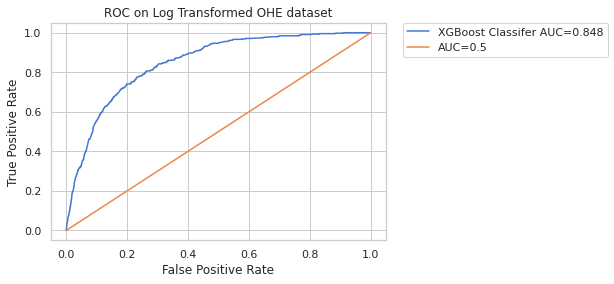

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer on Log Transformed OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055
3,XGBoost Classifer,Log Transformed OHE,0.132556,0.848140


# LightGBM Classifier

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=375,
                      reg_alpha = 0.4,
                      max_depth=7, random_state=42
                     )


In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165085	valid_0's auc: 0.810082
[2]	valid_0's binary_logloss: 0.163658	valid_0's auc: 0.823313
[3]	valid_0's binary_logloss: 0.162379	valid_0's auc: 0.829139
[4]	valid_0's binary_logloss: 0.161199	valid_0's auc: 0.831986
[5]	valid_0's binary_logloss: 0.160181	valid_0's auc: 0.831197
[6]	valid_0's binary_logloss: 0.1592	valid_0's auc: 0.831021
[7]	valid_0's binary_logloss: 0.158278	valid_0's auc: 0.830839
[8]	valid_0's binary_logloss: 0.157376	valid_0's auc: 0.832998
[9]	valid_0's binary_logloss: 0.156542	valid_0's auc: 0.832405
[10]	valid_0's binary_logloss: 0.155621	valid_0's auc: 0.83574
[11]	valid_0's binary_logloss: 0.154904	valid_0's auc: 0.835664
[12]	valid_0's binary_logloss: 0.154269	valid_0's auc: 0.834922
[13]	valid_0's binary_logloss: 0.153575	valid_0's auc: 0.835171
[14]	valid_0's binary_logloss: 0.152954	valid_0's auc: 0.835756
[15]	valid_0's binary_logloss: 0.152418	valid_0's auc: 0.835846
[16]	valid_0's binary_logloss: 0.151853	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.02, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=375, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed OHE dataset 		 



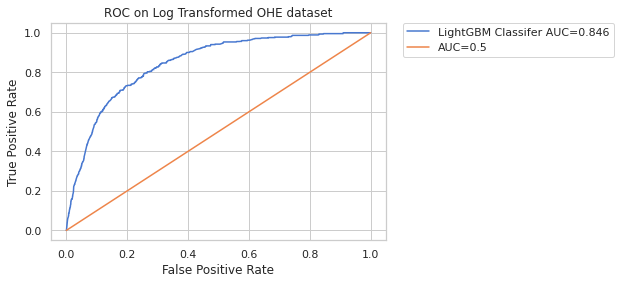

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Log Transformed OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055
3,XGBoost Classifer,Log Transformed OHE,0.132556,0.848140
4,LightGBM Classifer,Log Transformed OHE,0.132933,0.845743


# Random Forest (top 250)

In [18]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [19]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 62.7min finished


The best auc score was 0.820
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 5min 37s, sys: 672 ms, total: 5min 38s
Wall time: 1h 8min 17s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed OHE dataset 		 



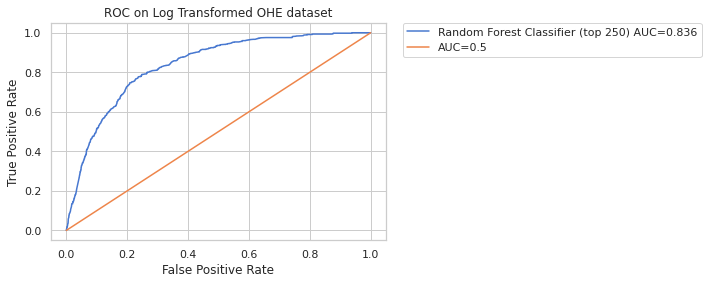

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (top 250) on Log Transformed OHE dataset.


In [ ]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055
3,XGBoost Classifer,Log Transformed OHE,0.132556,0.848140
4,LightGBM Classifer,Log Transformed OHE,0.132933,0.845743
5,Random Forest Classifier (top 250),Log Transformed OHE,0.136683,0.835698


# XGB Classifier (top 250)

In [ ]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0,
                      max_depth=6, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.80189	validation_0-error:0.04034
[1]	validation_0-auc:0.802263	validation_0-error:0.039902
[2]	validation_0-auc:0.808059	validation_0-error:0.039639
[3]	validation_0-auc:0.8174	validation_0-error:0.039639
[4]	validation_0-auc:0.819699	validation_0-error:0.039551
[5]	validation_0-auc:0.825406	validation_0-error:0.039551
[6]	validation_0-auc:0.826812	validation_0-error:0.039551
[7]	validation_0-auc:0.827184	validation_0-error:0.039551
[8]	validation_0-auc:0.827395	validation_0-error:0.039551
[9]	validation_0-auc:0.828242	validation_0-error:0.039551
[10]	validation_0-auc:0.829061	validation_0-error:0.039551
[11]	validation_0-auc:0.82857	validation_0-error:0.039551
[12]	validation_0-auc:0.828526	validation_0-error:0.039551
[13]	validation_0-auc:0.828826	validation_0-error:0.039551
[14]	validation_0-auc:0.828514	validation_0-error:0.039551
[15]	validation_0-auc:0.829195	validation_0-error:0.039551
[16]	validation_0-auc:0.82963	validation_0-error:0.039551
[17]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed OHE dataset 		 



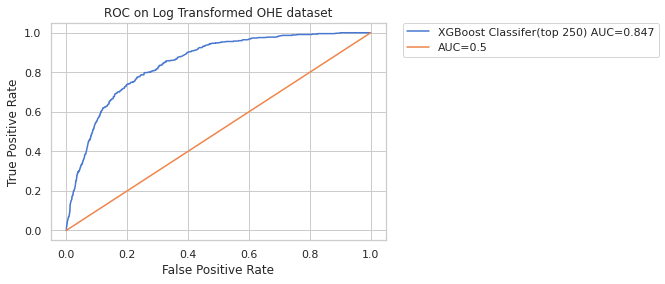

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Log Transformed OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [ ]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055
3,XGBoost Classifer,Log Transformed OHE,0.132556,0.848140
4,LightGBM Classifer,Log Transformed OHE,0.132933,0.845743
5,Random Forest Classifier (top 250),Log Transformed OHE,0.136683,0.835698
6,XGBoost Classifer(top 250),Log Transformed OHE,0.132707,0.847293


# LightGBM Classifier (top 250)

In [ ]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = .8,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=8, random_state=42
                     )

In [ ]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165838	valid_0's auc: 0.787733
[2]	valid_0's binary_logloss: 0.165145	valid_0's auc: 0.821467
[3]	valid_0's binary_logloss: 0.164526	valid_0's auc: 0.82018
[4]	valid_0's binary_logloss: 0.163872	valid_0's auc: 0.827189
[5]	valid_0's binary_logloss: 0.163338	valid_0's auc: 0.825091
[6]	valid_0's binary_logloss: 0.162707	valid_0's auc: 0.827368
[7]	valid_0's binary_logloss: 0.162098	valid_0's auc: 0.829241
[8]	valid_0's binary_logloss: 0.16155	valid_0's auc: 0.829214
[9]	valid_0's binary_logloss: 0.160981	valid_0's auc: 0.829917
[10]	valid_0's binary_logloss: 0.160459	valid_0's auc: 0.831389
[11]	valid_0's binary_logloss: 0.159919	valid_0's auc: 0.831099
[12]	valid_0's binary_logloss: 0.159395	valid_0's auc: 0.832813
[13]	valid_0's binary_logloss: 0.158939	valid_0's auc: 0.832456
[14]	valid_0's binary_logloss: 0.15848	valid_0's auc: 0.832348
[15]	valid_0's binary_logloss: 0.158038	valid_0's auc: 0.832037
[16]	valid_0's binary_logloss: 0.157584	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=42, reg_alpha=0, reg_lambda=0.0,
               scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed OHE dataset 		 



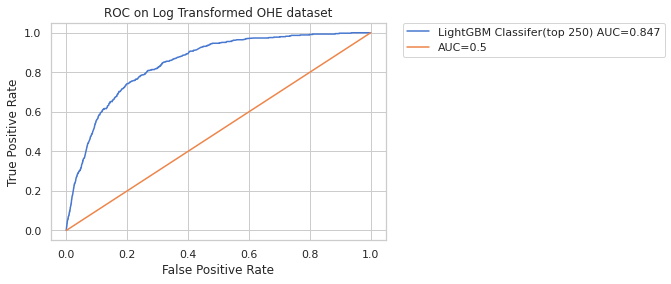

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Log Transformed OHE dataset.


In [ ]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

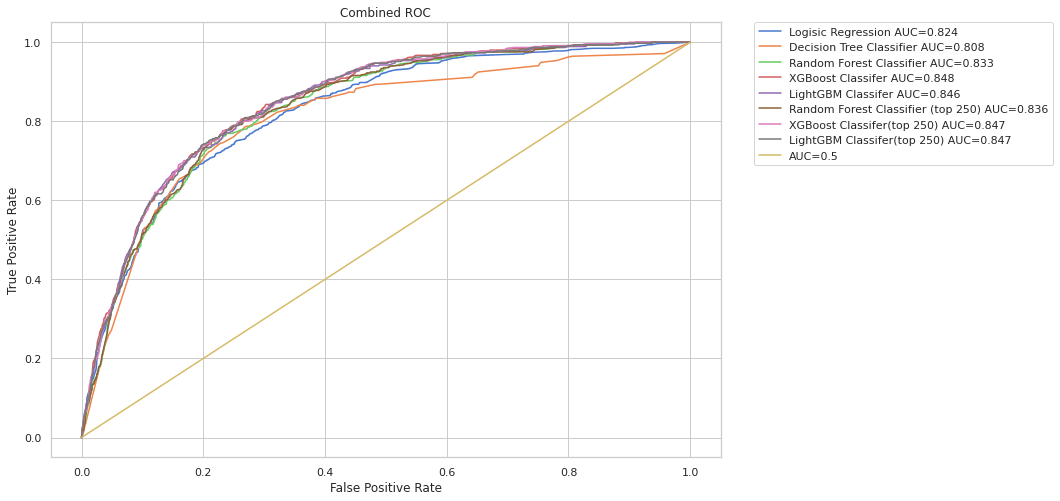

In [ ]:
plot_auc(y_val,y_preds,labels)

In [ ]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
3,XGBoost Classifer,Log Transformed OHE,0.132556,0.848140
6,XGBoost Classifer(top 250),Log Transformed OHE,0.132707,0.847293
7,LightGBM Classifer(top 250),Log Transformed OHE,0.133107,0.846686
4,LightGBM Classifer,Log Transformed OHE,0.132933,0.845743
5,Random Forest Classifier (top 250),Log Transformed OHE,0.136683,0.835698
2,Random Forest Classifier,Log Transformed OHE,0.137307,0.833055
0,Logisic Regression,Log Transformed OHE,0.518796,0.824365
1,Decision Tree Classifier,Log Transformed OHE,0.140781,0.807561


# Saving all the datasets created

In [ ]:
import joblib
filename = 'log_train_ohe.pkl'
X_train.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_ohe.pkl'
X_val.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_ohe.pkl'
X_test.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_train_ohe_250.pkl'
X_train_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_val_ohe_250.pkl'
X_val_200.to_pickle(os.path.join(file_path,'best_models',filename))

filename = 'log_test_ohe_250.pkl'
X_test_200.to_pickle(os.path.join(file_path,'best_models',filename))